In [44]:
import pydicom
from tkinter import Tk, filedialog
import os
import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import threshold_otsu
import cv2
from matplotlib.patches import Circle, Rectangle
import math

%config InlineBackend.figure_format = 'retina'




%matplotlib inline  
%config InlineBackend.figure_format = 'svg'

plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 20
plt.style.use(['seaborn-bright', 'seaborn-paper'])

In [2]:
# Generate a GUI to choose DICOM folder
def select_data_file():
    root = Tk()
    root.withdraw()
    root.attributes("-topmost", True)
    data_folder = filedialog.askdirectory(title="Select DICOM folder for analysis")
    root.destroy()

    if not data_folder:
        raise ValueError("Error: input folder not selected.")

    return data_folder

In [45]:
# Get the slice format of the pixel range
def get_pixel_range(center, width):
    ROI_half_start = math.floor(width / 2)
    ROI_half_end = math.ceil(width / 2)
    start = math.floor(center - ROI_half_start)
    end = math.floor(center + ROI_half_end)
    return slice(start, end)

In [155]:
DICOM_folder = select_data_file()
display(DICOM_folder)

dcm_list = []
for dirpath, dirnames, filenames in os.walk(DICOM_folder):
    for filename in filenames:
        file_path = os.path.join(dirpath, filename)
        dcm_list.append(file_path)
# display(dcm_list)

'F:/Data/MEGRE/202307.3.QUJIANXUN_MEGRE/BOLIN_NEW_EXAM_20230703_193446_845000/20230703_MEGRE_brain/MEGRE_V3_ES1_52_AVR10_FOV256_0003'

In [ ]:
#----------------------
#obj_thr = image_data > threshold_otsu(image_data)
#kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 10))
#obj_thr = cv2.morphologyEx(obj_thr.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
#obj_data = image_data*obj_thr
#---------------------

'Mean signal'

317.9195963541667

48

24

32

'ROI mean signal'

584.29

slice(27, 37, None)

slice(19, 29, None)

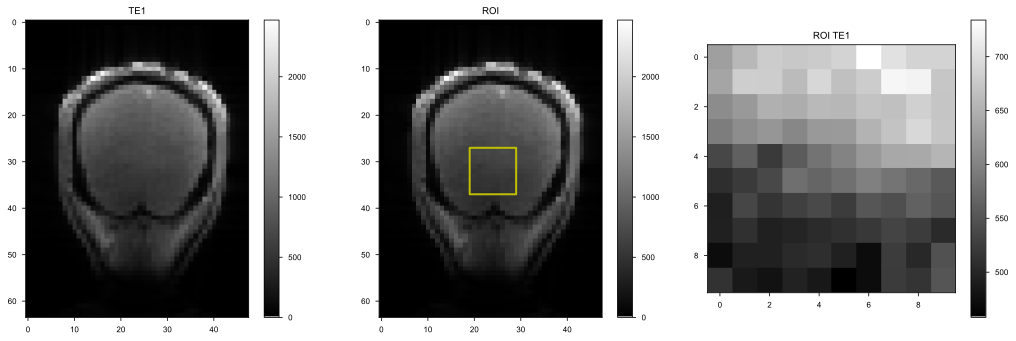

In [156]:
dcm_path = dcm_list[0]
dcm = pydicom.dcmread(dcm_path)
image_data = dcm.pixel_array
obj_data = image_data

mean_signal = np.nanmean(obj_data)
display('Mean signal',mean_signal)

x_dim = obj_data.shape[0]
y_dim = obj_data.shape[1]
display(y_dim)

x_pos = y_dim//2
y_pos = x_dim//2
roi_width = 10
display(x_pos,y_pos)

ROI_x = get_pixel_range(x_dim//2, roi_width)
ROI_y = get_pixel_range(y_dim//2, roi_width)
ROI_data = obj_data[ROI_x,ROI_y]
ROI_mean_signal = np.nanmean(ROI_data)
rect = Rectangle((x_pos-5, y_pos-5), roi_width,roi_width, linewidth=2, edgecolor='y', facecolor='none')
display('ROI mean signal',ROI_mean_signal)
display(ROI_x,ROI_y)


# Plot
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

img = axes[0].imshow(obj_data, cmap=plt.cm.gray)
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TE1')


img = axes[1].imshow(obj_data, cmap=plt.cm.gray)
fig.colorbar(img,ax=axes[1])
axes[1].set_title('ROI')
axes[1].add_patch(rect)

img = axes[2].imshow(ROI_data, cmap=plt.cm.gray)
fig.colorbar(img,ax=axes[2])
axes[2].set_title('ROI TE1')

plt.tight_layout()

In [157]:

mean_list=[]
ROI_list=[]
x_dim = obj_data.shape[0]
y_dim = obj_data.shape[1]
x_pos = y_dim//2
y_pos = x_dim//2
roi_width = 10
ROI_x = get_pixel_range(y_pos, roi_width)
ROI_y = get_pixel_range(x_pos, roi_width)

for dcm_path in dcm_list:
    # 读取DICOM文件
    dcm = pydicom.dcmread(dcm_path)
    # 提取图像数据
    image_data = dcm.pixel_array
    obj_data = image_data

    mean_signal = np.nanmean(obj_data)
    mean_list.append(mean_signal)

    ROI_data = obj_data[ROI_x,ROI_y]
    ROI_mean_signal = np.nanmean(ROI_data)
    ROI_list.append(ROI_mean_signal)


# display(mean_list)

# Siemens: activation=odd, baseline=even
activation_mean=mean_list[::2]
baseline_mean=mean_list[1::2]
delta_percent_mean = [(a-b)/(b+1e-8) for a, b in zip(activation_mean, baseline_mean)]

activation_ROI=ROI_list[::2]
baseline_ROI=ROI_list[1::2]
delta_percent_ROI = [(a-b)/(b+1e-8) for a, b in zip(activation_ROI, baseline_ROI)]


"""
# GE: activation, and then baseline
half_length = len(mean_list) // 2
activation_mean=mean_list[half_length:]
baseline_mean=mean_list[:half_length]
delta_percent_mean = [(a-b)/(b+1e-8) for a, b in zip(activation_mean, baseline_mean)]

activation_center=center_list[half_length:]
baseline_center=center_list[:half_length]
delta_percent_center = [(a-b)/(b+1e-8) for a, b in zip(activation_center, baseline_center)]
"""

'\n# GE: activation, and then baseline\nhalf_length = len(mean_list) // 2\nactivation_mean=mean_list[half_length:]\nbaseline_mean=mean_list[:half_length]\ndelta_percent_mean = [(a-b)/(b+1e-8) for a, b in zip(activation_mean, baseline_mean)]\n\nactivation_center=center_list[half_length:]\nbaseline_center=center_list[:half_length]\ndelta_percent_center = [(a-b)/(b+1e-8) for a, b in zip(activation_center, baseline_center)]\n'

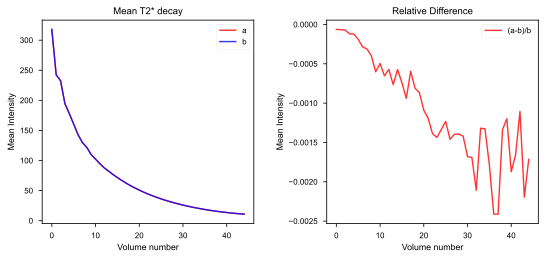

In [158]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].plot(activation_mean,color='r',alpha=0.8,label='a')
axes[0].plot(baseline_mean,color='b',alpha=0.8,label='b')
axes[0].set_xlabel("Volume number")
axes[0].set_ylabel("Mean Intensity")
axes[0].set_title('Mean T2* decay')
axes[0].legend()

axes[1].plot(delta_percent_mean,color='r',alpha=0.8,label='(a-b)/b')
axes[1].set_xlabel("Volume number")
axes[1].set_ylabel("Mean Intensity")
axes[1].set_title('Relative Difference')
axes[1].legend()


plt.tight_layout()

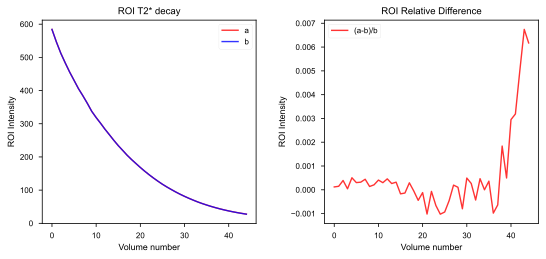

In [159]:

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].plot(activation_ROI,color='r',alpha=0.8,label='a')
axes[0].plot(baseline_ROI,color='b',alpha=0.8,label='b')
axes[0].set_xlabel("Volume number")
axes[0].set_ylabel("ROI Intensity")
axes[0].set_title('ROI T2* decay')
axes[0].legend()

axes[1].plot(delta_percent_ROI,color='r',alpha=0.8,label='(a-b)/b')
axes[1].set_xlabel("Volume number")
axes[1].set_ylabel("ROI Intensity")
axes[1].set_title('ROI Relative Difference')
axes[1].legend()


plt.tight_layout()

In [11]:
display(activation_mean)

[362.801513671875,
 345.01953125,
 329.90380859375,
 314.384033203125,
 299.111328125,
 285.468017578125,
 272.27099609375,
 259.312255859375,
 247.203125,
 235.652099609375,
 224.625,
 214.206787109375,
 204.266357421875,
 194.7431640625,
 185.588623046875,
 176.87841796875,
 168.58056640625,
 160.630126953125,
 153.0859375,
 145.87890625,
 138.958740234375,
 132.328857421875,
 126.022705078125,
 119.99853515625,
 114.256103515625,
 108.795654296875,
 103.567626953125,
 98.591796875,
 93.834716796875,
 89.303466796875,
 84.968017578125,
 80.833251953125,
 76.9111328125,
 73.160888671875,
 69.58251953125,
 66.174072265625,
 62.91357421875,
 59.81298828125,
 56.865478515625,
 54.049072265625,
 51.372802734375,
 48.814697265625,
 46.38427734375,
 44.065673828125,
 41.86376953125]